In [88]:
from datetime import datetime

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [89]:
bids = np.load('data/bid_record.npy')
asks = np.load('data/ask_record.npy')
times = np.array(list(map(np.datetime64, map(datetime.fromtimestamp, np.load('data/time_record.npy')))))
print(bids.shape)
LEVELS = bids.shape[1]

(40000, 64, 2)


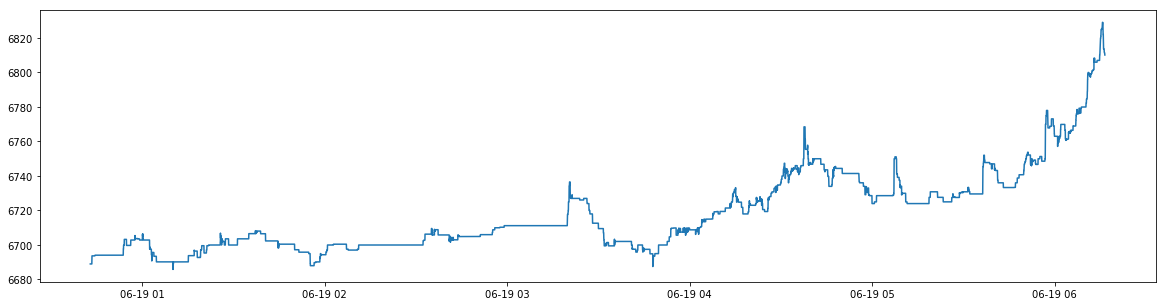

In [132]:
plt.figure(figsize=(20,5))
mid_price = (bids[:, -1, 0] + asks[:, 0, 0]) / 2
plt.plot_date(times, mid_price, fmt='-')

In [114]:
def get_aggregate_volume(data, is_bid = None, agg_sz = None):
    prices = data[:, :, 0]
    vols = data[:, :, 1]
    best_bid_prices = bid_prices[:, 0 - is_bid]
    if is_bid:
        in_agg_rng = bid_prices > (best_bid_prices.repeat(LEVELS).reshape(-1, LEVELS) - agg_sz)
    else: # asks
        in_agg_rng = bid_prices < (best_bid_prices.repeat(LEVELS).reshape(-1, LEVELS) + agg_sz)
    agg_bid_vols = (bid_vols * in_agg_rng).sum(axis=1)
    return agg_bid_vols

In [229]:
def get_bof(df):
    """bof := bid order flow"""
    bids = df['bid']
    sr_bids = bids.shift(1)
    bid_eq = (bids == sr_bids)
    bid_g = (bids > sr_bids)

    bid_vol = df['bid-volume']
    sr_bid_vol = bid_vol.shift(1)

    bof = bid_eq * (bid_vol - sr_bid_vol) + bid_g * bid_vol
    return bof

def get_aof(df):
    """aof := ask order flow"""
    asks = df['ask']
    sr_asks = asks.shift(1)
    ask_eq = (asks == sr_asks)
    ask_l = (asks < sr_asks)

    ask_vol = df['ask-volume']
    sr_ask_vol = ask_vol.shift(1)

    aof = ask_eq * (ask_vol - sr_ask_vol) + ask_l * ask_vol
    return aof

def get_oi(df):
    """oi := order imbalance,
    per http://eprints.maths.ox.ac.uk/1895/1/Darryl%20Shen%20(for%20archive).pdf"""
    oi = get_bof(df) - get_aof(df)
    return oi

In [247]:
AGG_SZ = 5 # USD
agg_bid_vol = get_aggregate_volume(bids, is_bid=True, agg_sz=AGG_SZ)
agg_ask_vol = get_aggregate_volume(asks, is_bid=False, agg_sz=AGG_SZ)
agg_oir = (agg_bid_vol - agg_ask_vol) / (agg_bid_vol + agg_ask_vol)

df = pd.DataFrame(data={'bid': bids[:, -1, 0],
                        'ask': asks[:, 0, 0],
                        'bid-volume': agg_bid_vol,
                        'ask-volume': agg_ask_vol,
                        'mid': mid_price,
                        'oir': agg_oir,
                        'time': times})

df['dmid'] = df['mid'] - df['mid'].shift(1)
df['oi'] = get_oi(df)

df[0:3]

,bid,ask,bid-volume,ask-volume,mid,oir,time,dmid,oi
0,6689.01,6689.02,53.554381,14.814496,6689.015,0.566630,2018-06-19 00:42:54.055098,NaN,NaN
1,6689.01,6689.02,53.554381,14.814496,6689.015,0.566630,2018-06-19 00:42:54.555490,0.0,0.000000
2,6689.01,6689.02,53.554381,14.799493,6689.015,0.566974,2018-06-19 00:42:55.055927,0.0,0.015003


(<BarContainer object of 30 artists>, Text(0.5,1,'voi-dmid-corr'))

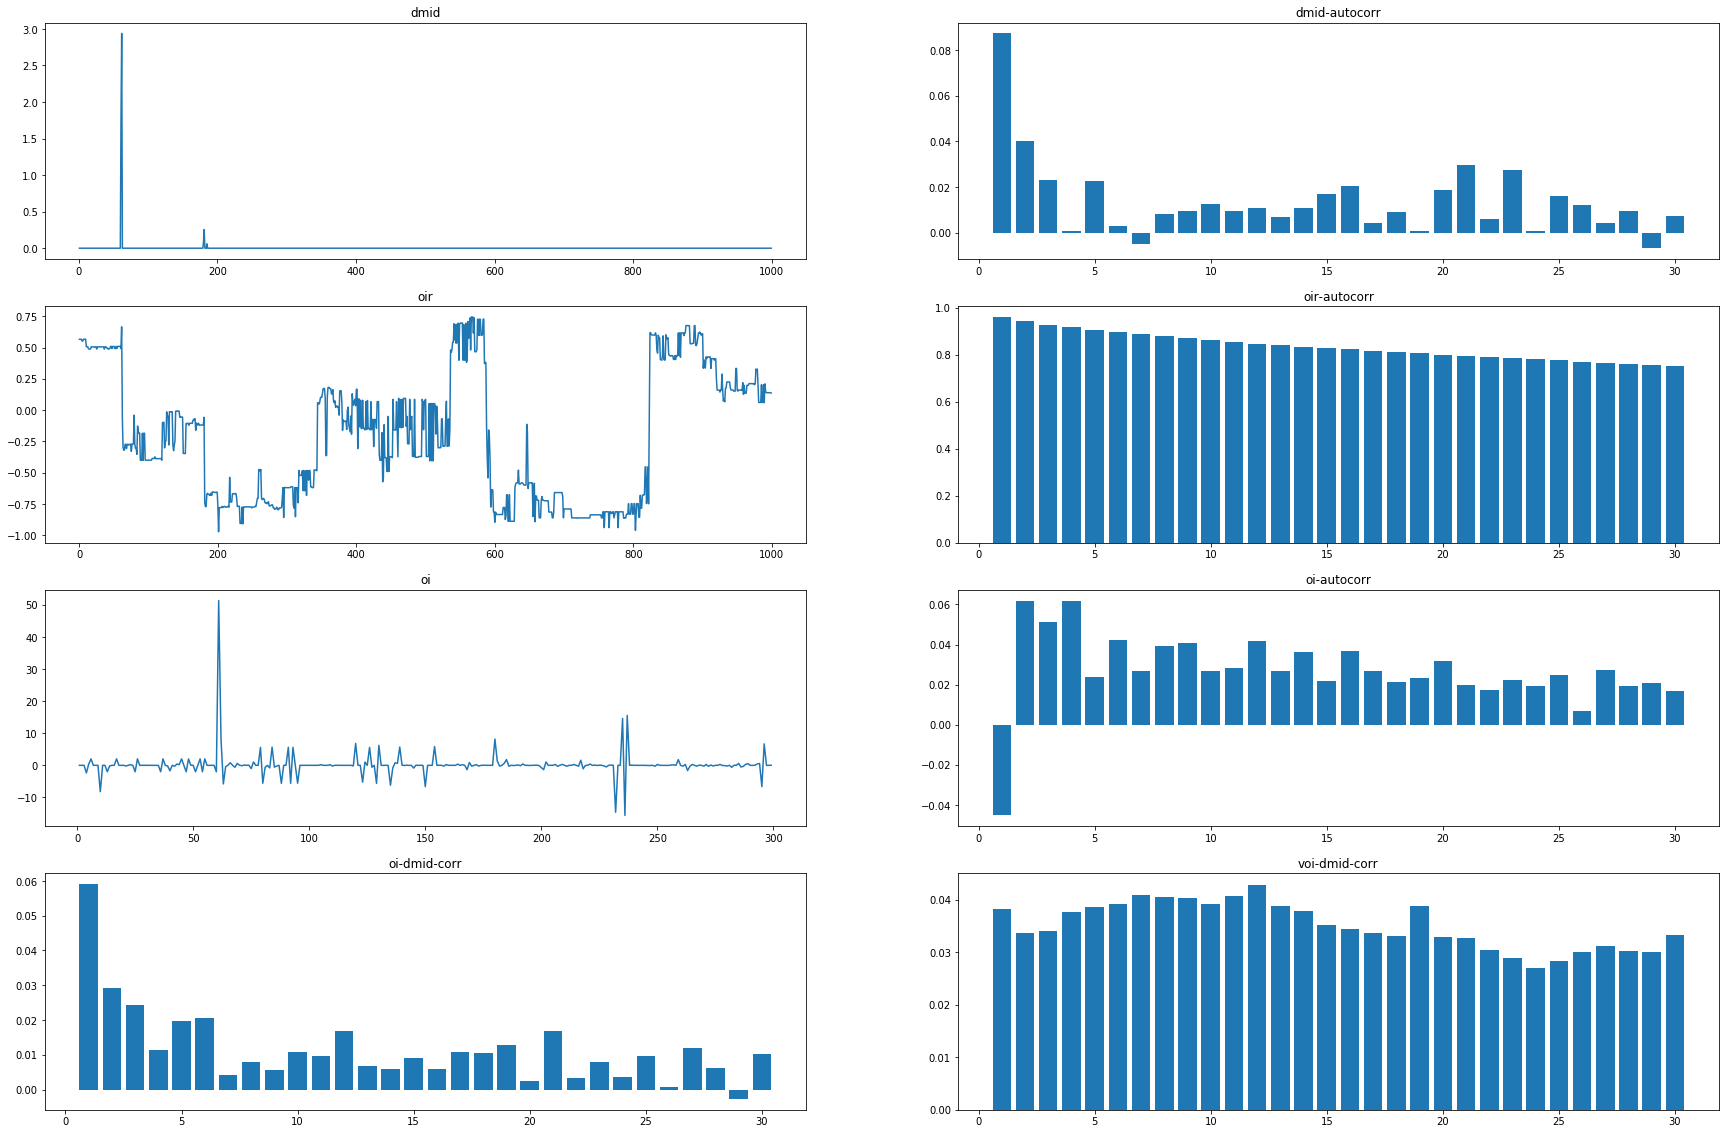

In [248]:
plt.figure(figsize=(30,20))

height = 4

plt.subplot(height, 2, 1)
plt.plot(df['dmid'][0:1000]), plt.title('dmid')
plt.subplot(height, 2, 2)
lags = np.arange(30) + 1
plt.bar(lags, [df['dmid'].autocorr(lag=lag) for lag in lags]), plt.title('dmid-autocorr')

plt.subplot(height, 2, 3)
plt.plot(df['oir'][0:1000]), plt.title('oir')
plt.subplot(height, 2, 4)
lags = np.arange(30) + 1
plt.bar(lags, [df['oir'].autocorr(lag=lag) for lag in lags]), plt.title('oir-autocorr')

plt.subplot(height, 2, 5)
plt.plot(df['oi'][0:300]), plt.title('oi')
plt.subplot(height, 2, 6)
lags = np.arange(30) + 1
plt.bar(lags, [df['oi'].autocorr(lag=lag) for lag in lags]), plt.title('oi-autocorr')

plt.subplot(height, 2, 7)
lags = np.arange(30) + 1
plt.bar(lags, [df['oi'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('oi-dmid-corr')
plt.subplot(height, 2, 8)
lags = np.arange(30) + 1
plt.bar(lags, [df['oir'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('voi-dmid-corr')